## 컴퓨터 비전을 위한 전이학습

- 합성곱 신경망의 미세조정 : 무작위 초기화 대신, 신경망을 데이터셋으로 미리 학습한 신경망으로 초기화합니다. 학습의 나머지 과정들은 평상시와 똑같습니다.
- 고정된 특징 추출기로써의 합성곱 신경망: 여기서는 마지막에 완전히 연결 된 계층을 제외한 모든 신경망의 가중치를 고정합니다. 이 마지막의 완전히 연결된 계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습합니다.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision 
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.backmark = True
plt.ion()

## 데이터 불러오기

In [10]:
import torch.utils


data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders= {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 일부 이미지 시각화하기

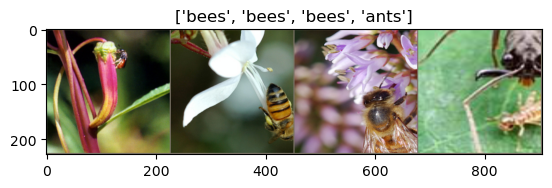

In [14]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 모델 학습하기

- 학습률 관리
- 최적의 모델 구하기

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0


                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase =='train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_size[phase]
                epoch_acc = running_corrects.double() / dataset_size[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()
        
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

## 모델 예측값 시각화 하기

In [28]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fir = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode=was_training)

## 합성곱 신경망 미세조정

In [29]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 학습및 평가하기

In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


train Loss: 0.6052 Acc: 0.6680
val Loss: 0.2759 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.5480 Acc: 0.7582
val Loss: 0.2126 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4880 Acc: 0.7951
val Loss: 0.2343 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3997 Acc: 0.8361
val Loss: 0.6637 Acc: 0.7124

Epoch 4/24
----------
train Loss: 0.4847 Acc: 0.8484
val Loss: 0.5337 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.4840 Acc: 0.8156
val Loss: 0.2757 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3931 Acc: 0.8361
val Loss: 0.3008 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.5342 Acc: 0.7787
val Loss: 0.1608 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.4033 Acc: 0.8238
val Loss: 0.1736 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2884 Acc: 0.8893
val Loss: 0.1752 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2929 Acc: 0.8893
val Loss: 0.1619 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3524 Acc: 0.8525
val Loss: 0.2462 Acc: 0.9346

Epoch 12/24
----------
t

/tmp/ipykernel_15425/3167067587.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


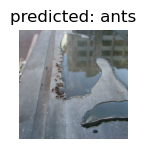

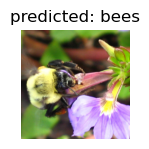

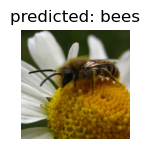

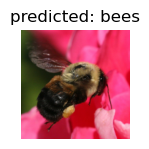

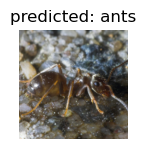

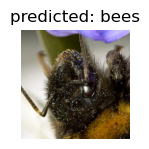

In [31]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망

In [32]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## 학습 및 평가하기

In [34]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3547 Acc: 0.8443
val Loss: 0.1480 Acc: 0.9673

Epoch 1/24
----------
train Loss: 0.4242 Acc: 0.8320
val Loss: 0.1558 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3697 Acc: 0.8279
val Loss: 0.1493 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.3800 Acc: 0.8279
val Loss: 0.1443 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.2915 Acc: 0.8770
val Loss: 0.1582 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.3435 Acc: 0.8320
val Loss: 0.1556 Acc: 0.9739

Epoch 6/24
----------
train Loss: 0.4099 Acc: 0.8197
val Loss: 0.1491 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3679 Acc: 0.8361
val Loss: 0.1420 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3275 Acc: 0.8402
val Loss: 0.1445 Acc: 0.9673

Epoch 9/24
----------
train Loss: 0.3367 Acc: 0.8607
val Loss: 0.1541 Acc: 0.9739

Epoch 10/24
----------
train Loss: 0.3359 Acc: 0.8484
val Loss: 0.1461 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3684 Acc: 0.8320
val Loss: 0.1422 Acc: 0.9608

Ep

/tmp/ipykernel_15425/3167067587.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


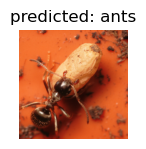

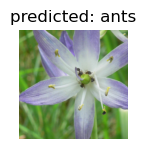

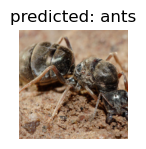

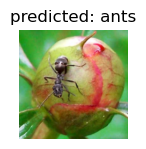

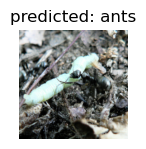

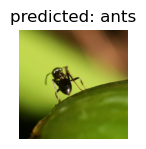

In [35]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 다른 이미지들에 대한 추론

In [36]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

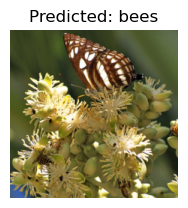

In [37]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()